<a href="https://colab.research.google.com/github/fatehOurghi/face-detection-evaluation/blob/main/notebook_FD_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of face detection algorithms

This colab notebook will be used to evaluate different face detection algorithms including:
1.   TinaFace (best of Wider Face)
2.   DSFD (best of FDDB)
3.   SRN (best of Pascal Face)
---
Datasets used in this evaluation are:
*   Wider Face
*   FDDB
*   Pascal Face

In [ ]:
# %tensorflow_version 1.x

**Machine configurations**

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Prepare algorithms

In [ ]:
#@title Imports and global constants
# install face_detection framework
!pip install face-detection
!pip install utils
!pip install yapf
# imports
import cv2
import face_detection
import time
import os,sys
import os.path as osp
import json
import numpy as np
import torch
from utils import *
from google.colab.patches import cv2_imshow
import colorsys
import tensorflow.python.keras.backend as K
from tensorflow.python.keras.models import load_model
from timeit import default_timer as timer
from PIL import ImageDraw, Image
import tensorflow as tf

ROOT = '/content/drive/MyDrive/Datasets/FaceDetection/'
EVAL_FOLDER = "/content/drive/MyDrive/Evaluations/"
MODEL_FOLDER = "/content/drive/MyDrive/Models/FaceDetection/"

In [19]:
#@title DSFD detector
# prepare detection and evaluation for DSFD
def dsfd_detector_eval(annotations, images_folder):
  # prepare detector
  detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)
  detections_list = []
  for annotation_doc in annotations:
    for annotation in annotation_doc['annotations']:
      path_to_img = f"{images_folder}{annotation['filename']}"
      if not (path_to_img.endswith('.jpg') or path_to_img.endswith('.png')):
        path_to_img = path_to_img + '.jpg'
      im = cv2.imread(path_to_img)
      start = time.time()
      bounding_boxes = detector.detect(im)
      inference_time = time.time() - start
      detection = {
          'filename': annotation['filename'],
          'inference_time': inference_time,
          'count': len(bounding_boxes),
          'faces': [{
              'top_left': (int(box[0]), int(box[1])),
              'bottom_right': (int(box[2]), int(box[3]))
          } for box in bounding_boxes]
      }
      '''
      bboxes = annotation['faces']
      print(bboxes)
      for box in bboxes:
        tl = (int(box['top_left'][0]), int(box['top_left'][1]))
        br = (int(box['bottom_right'][0]), int(box['bottom_right'][1]))
        print(tl)
        cv2.rectangle(im, tl, br, (0,0,255), 2)


      for box in bounding_boxes:
        cv2.rectangle(im, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255,0,0), 2)
      cv2_imshow(im)'''
      detections_list.append(detection)
      #break
    #break
  return detections_list

def evaluate_dsfd_and_write_to_file(annotations, images_folder):
  algorithm = 'DSFD'
  detections_list = dsfd_detector_eval(annotations, images_folder)

  mean_time = np.mean([detection['inference_time'] for detection in detections_list])

  evaluation = {
      'dataset': DATASET,
      'algorithm': algorithm, 
      'mean_time': mean_time,
      'detections': detections_list
  }

  eval_file = open(f'{EVAL_FOLDER}Predictions of {algorithm} on {DATASET} dataset.json', 'w')
  eval_file.write(json.dumps(evaluation))
  eval_file.close()

In [ ]:
#@title YOLOFace detector - CPU
CONF_THRESHOLD = 0.5
NMS_THRESHOLD = 0.4
IMG_WIDTH = 416
IMG_HEIGHT = 416

# -------------------------------------------------------------------
# Help functions
# -------------------------------------------------------------------

def refined_box(left, top, width, height):
    right = left + width
    bottom = top + height

    original_vert_height = bottom - top
    top = int(top + original_vert_height * 0.15)
    bottom = int(bottom - original_vert_height * 0.05)

    margin = ((bottom - top) - (right - left)) // 2
    left = left - margin if (bottom - top - right + left) % 2 == 0 else left - margin - 1

    right = right + margin

    return left, top, right, bottom


# Get the names of the output layers
def get_outputs_names(net):
    # Get the names of all the layers in the network
    layers_names = net.getLayerNames()

    # Get the names of the output layers, i.e. the layers with unconnected
    # outputs
    return [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]


def post_process(frame, outs, conf_threshold, nms_threshold):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only
    # the ones with high confidence scores. Assign the box's class label as the
    # class with the highest score.
    confidences = []
    boxes = []
    final_boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * frame_width)
                center_y = int(detection[1] * frame_height)
                width = int(detection[2] * frame_width)
                height = int(detection[3] * frame_height)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant
    # overlapping boxes with lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold,
                               nms_threshold)

    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        left, top, right, bottom = refined_box(left, top, width, height)
        box = {
            'top_left': (int(left), int(top)),
            'bottom_right': (int(right), int(bottom))
        }
        final_boxes.append(box)

    return final_boxes

def yoloface_detector():
  model_cfg = f"{MODEL_FOLDER}cfg/yolov3-face.cfg"
  model_weights = f"{MODEL_FOLDER}yolov3-wider_16000.weights"
  net = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)
  net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
  net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16)
  return net

def run_yoloface(detector, image):
  blob = cv2.dnn.blobFromImage(image, 1 / 255, (IMG_WIDTH, IMG_HEIGHT), [0, 0, 0], 1, crop=False)
  detector.setInput(blob)
  outs = detector.forward(get_outputs_names(detector))
  faces = post_process(image, outs, CONF_THRESHOLD, NMS_THRESHOLD)
  return faces


# prepare detection and evaluation for YOLOFace
def yoloface_detector_eval(annotations, images_folder):
  # prepare detector
  detector = yoloface_detector()
  detections_list = []
  for annotation_doc in annotations:
    for annotation in annotation_doc['annotations']:
      path_to_img = f"{images_folder}{annotation['filename']}"
      if not path_to_img.endswith('.jpg'):
        path_to_img = path_to_img + '.jpg'
      im = cv2.imread(path_to_img)
      start = time.time()
      bounding_boxes = run_yoloface(detector, im)
      inference_time = time.time() - start
      detection = {
          'filename': annotation['filename'],
          'inference_time': inference_time,
          'count': len(bounding_boxes),
          'faces': bounding_boxes
      }
      detections_list.append(detection)
  return detections_list

def evaluate_yoloface_and_write_to_file(annotations, images_folder):
  algorithm = 'YOLOFACE'
  detections_list = yoloface_detector_eval(annotations, images_folder)
  mean_time = np.mean([detection['inference_time'] for detection in detections_list])

  evaluation = {
      'dataset': DATASET,
      'algorithm': algorithm,
      'mean_time': mean_time,
      'detections': detections_list
  }
  eval_file = open(f'{EVAL_FOLDER}Predictions of {algorithm} on {DATASET} dataset.json', 'w')
  eval_file.write(json.dumps(evaluation))
  eval_file.close()

In [ ]:
#@title FaceBoxes pytorch Model
import tensorflow.compat.v1 as tf1
import numpy as np


class FaceDetector:
    def __init__(self, model_path, gpu_memory_fraction=0.25, visible_device_list='0'):
        """
        Arguments:
            model_path: a string, path to a pb file.
            gpu_memory_fraction: a float number.
            visible_device_list: a string.
        """
        with tf1.io.gfile.GFile(model_path, 'rb') as f:
            graph_def = tf1.GraphDef()
            graph_def.ParseFromString(f.read())

        graph = tf1.Graph()
        with graph.as_default():
            tf1.import_graph_def(graph_def, name='import')

        self.input_image = graph.get_tensor_by_name('import/image_tensor:0')
        self.output_ops = [
            graph.get_tensor_by_name('import/boxes:0'),
            graph.get_tensor_by_name('import/scores:0'),
            graph.get_tensor_by_name('import/num_boxes:0'),
        ]

        gpu_options = tf1.GPUOptions(
            per_process_gpu_memory_fraction=gpu_memory_fraction,
            visible_device_list=visible_device_list
        )
        config_proto = tf1.ConfigProto(gpu_options=gpu_options, log_device_placement=False)
        self.sess = tf1.Session(graph=graph, config=config_proto)

    def __call__(self, image, score_threshold=0.5):
        """Detect faces.
        Arguments:
            image: a numpy uint8 array with shape [height, width, 3],
                that represents a RGB image.
            score_threshold: a float number.
        Returns:
            boxes: a float numpy array of shape [num_faces, 4].
            scores: a float numpy array of shape [num_faces].
        Note that box coordinates are in the order: ymin, xmin, ymax, xmax!
        """
        h, w, _ = image.shape
        image = np.expand_dims(image, 0)

        boxes, scores, num_boxes = self.sess.run(
            self.output_ops, feed_dict={self.input_image: image}
        )
        num_boxes = num_boxes[0]
        boxes = boxes[0][:num_boxes]
        scores = scores[0][:num_boxes]

        to_keep = scores > score_threshold
        boxes = boxes[to_keep]
        scores = scores[to_keep]

        scaler = np.array([h, w, h, w], dtype='float32')
        boxes = boxes * scaler

        return boxes, scores

In [ ]:
#@title FaceBoxes Detector
%tensorflow_version 1.x
# prepare detection and evaluation for FaceBoxes
def faceboxes_detector_eval(annotations, images_folder):
  # prepare detector
  FACEBOXES_MODEL = f"{MODEL_FOLDER}faceboxes.pb"
  detector = FaceDetector(FACEBOXES_MODEL)
  detections_list = []
  for annotation_doc in annotations:
    for annotation in annotation_doc['annotations']:
      path_to_img = f"{images_folder}{annotation['filename']}"
      if not (path_to_img.endswith('.jpg') or path_to_img.endswith('.png')):
        path_to_img = path_to_img + '.jpg'
      im = cv2.imread(path_to_img)
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      start = time.time()
      bounding_boxes, scores = detector(im)
      inference_time = time.time() - start
      detection = {
          'filename': annotation['filename'],
          'inference_time': inference_time,
          'count': len(bounding_boxes),
          'faces': [{
              'top_left': (int(box[1]), int(box[0])),
              'bottom_right': (int(box[3]), int(box[2]))
          } for box, score in zip(bounding_boxes, scores)]
      }
      for box in bounding_boxes:
        cv2.rectangle(im, (int(box[1]), int(box[0])), (int(box[3]), int(box[2])), (0,0,255),1)
      cv2_imshow(im)
      break
      detections_list.append(detection)
    break
  return detections_list

def evaluate_faceboxes_and_write_to_file(annotations, images_folder):
  algorithm = 'FaceBoxes'
  detections_list = faceboxes_detector_eval(annotations, images_folder)

  mean_time = np.mean([detection['inference_time'] for detection in detections_list])

  evaluation = {
      'dataset': DATASET,
      'algorithm': algorithm, 
      'mean_time': mean_time,
      'detections': detections_list
  }

  #eval_file = open(f'{EVAL_FOLDER}Predictions of {algorithm} on {DATASET} dataset.json', 'w')
  #eval_file.write(json.dumps(evaluation))
  #eval_file.close()

In [16]:
#@title TinaFace

from itertools import chain
from torch.nn.parallel import DataParallel
from torch.nn.parallel._functions import Scatter as OrigScatter
import inspect



def scatter(inputs, target_gpus, dim=0):
    """Scatter inputs to target gpus.
    The only difference from original :func:`scatter` is to add support for
    :type:`~parallel.DataContainer`.
    """

    def scatter_map(obj):
        if isinstance(obj, torch.Tensor):
            return OrigScatter.apply(target_gpus, None, dim, obj)
        if isinstance(obj, DataContainer):
            if obj.cpu_only:
                return obj.data
            else:
                return Scatter.forward(target_gpus, obj.data)
        if isinstance(obj, tuple) and len(obj) > 0:
            return list(zip(*map(scatter_map, obj)))
        if isinstance(obj, list) and len(obj) > 0:
            out = list(map(list, zip(*map(scatter_map, obj))))
            return out
        if isinstance(obj, dict) and len(obj) > 0:
            out = list(map(type(obj), zip(*map(scatter_map, obj.items()))))
            return out
        return [obj for targets in target_gpus]

    # After scatter_map is called, a scatter_map cell will exist. This cell
    # has a reference to the actual function scatter_map, which has references
    # to a closure that has a reference to the scatter_map cell (because the
    # fn is recursive). To avoid this reference cycle, we set the function to
    # None, clearing the cell
    try:
        return scatter_map(inputs)
    finally:
        scatter_map = None


def scatter_kwargs(inputs, kwargs, target_gpus, dim=0):
    """Scatter with support for kwargs dictionary"""
    inputs = scatter(inputs, target_gpus, dim) if inputs else []
    kwargs = scatter(kwargs, target_gpus, dim) if kwargs else []
    if len(inputs) < len(kwargs):
        inputs.extend([() for _ in range(len(kwargs) - len(inputs))])
    elif len(kwargs) < len(inputs):
        kwargs.extend([{} for _ in range(len(inputs) - len(kwargs))])
    inputs = tuple(inputs)
    kwargs = tuple(kwargs)
    return inputs, kwargs


class MMDataParallel(DataParallel):

    def scatter(self, inputs, kwargs, device_ids):
        return scatter_kwargs(inputs, kwargs, device_ids, dim=self.dim)

    def forward(self, *inputs, **kwargs):
        if not self.device_ids:
            return self.module(*inputs, **kwargs)

        assert len(self.device_ids) == 1, \
            ('MMDataParallel only supports single GPU training, if you need to'
             ' train with multiple GPUs, please use MMDistributedDataParallel'
             'instead.')

        for t in chain(self.module.parameters(), self.module.buffers()):
            if t.device != self.src_device_obj:
                raise RuntimeError(
                    'module must have its parameters and buffers '
                    f'on device {self.src_device_obj} (device_ids[0]) but '
                    f'found one of them on device: {t.device}')

        inputs, kwargs = self.scatter(inputs, kwargs, self.device_ids)
        return self.module(*inputs[0], **kwargs[0])



class Registry:
    """A registry to map strings to classes.
    Args:
        name (str): Registry name.
    """
    _instance = None

    def __init__(self):
        self._module_dict = dict()

    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kwargs)
        return cls._instance

    def __len__(self):
        return len(self._module_dict)

    def __contains__(self, key):
        return self.get(key) is not None

    def __repr__(self):
        format_str = self.__class__.__name__ + \
                     f'(items={self._module_dict})'
        return format_str

    @property
    def module_dict(self):
        return self._module_dict

    def get(self, cls_name, module_name='module'):
        """Get the registry record.
        Args:
            key (str): The class name in string format.
        Returns:
            class: The corresponding class.
        """
        if module_name not in self._module_dict:
            raise KeyError(f'{module_name} is not in registry')
        dd = self._module_dict[module_name]
        if cls_name not in dd:
            raise KeyError(f'{cls_name} is not registered in {module_name}')

        return dd[cls_name]

    def _register_module(self, cls, module_name):
        if not inspect.isclass(cls):
            raise TypeError('module must be a class, ' f'but got {type(cls)}')

        cls_name = cls.__name__
        self._module_dict.setdefault(module_name, dict())
        dd = self._module_dict[module_name]
        if cls_name in dd:
            raise KeyError(f'{cls_name} is already registered '
                           f'in {module_name}')
        dd[cls_name] = cls

    def register_module(self, module_name='module'):

        def _register(cls):
            self._register_module(cls, module_name)
            return cls

        return _register



def load_state_dict(module, state_dict, strict=False, logger=None):
    """Load state_dict to a module.
    This method is modified from :meth:`torch.nn.Module.load_state_dict`.
    Default value for ``strict`` is set to ``False`` and the message for
    param mismatch will be shown even if strict is False.
    Args:
        module (Module): Module that receives the state_dict.
        state_dict (OrderedDict): Weights.
        strict (bool): whether to strictly enforce that the keys
            in :attr:`state_dict` match the keys returned by this module's
            :meth:`~torch.nn.Module.state_dict` function. Default: ``False``.
        logger (:obj:`logging.Logger`, optional): Logger to log the error
            message. If not specified, print function will be used.
    """
    unexpected_keys = []
    all_missing_keys = []
    err_msg = []

    metadata = getattr(state_dict, '_metadata', None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    # use _load_from_state_dict to enable checkpoint version control
    def load(module, prefix=''):
        # recursively check parallel module in case that the model has a
        # complicated structure, e.g., nn.Module(nn.Module(DDP))
        if is_module_wrapper(module):
            module = module.module
        local_metadata = {} if metadata is None else metadata.get(
            prefix[:-1], {})
        module._load_from_state_dict(state_dict, prefix, local_metadata, True,
                                     all_missing_keys, unexpected_keys,
                                     err_msg)
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + '.')

    load(module)
    load = None  # break load->load reference cycle

    # ignore "num_batches_tracked" of BN layers
    missing_keys = [
        key for key in all_missing_keys if 'num_batches_tracked' not in key
    ]

    if unexpected_keys:
        err_msg.append('unexpected key in source '
                       f'state_dict: {", ".join(unexpected_keys)}\n')
    if missing_keys:
        err_msg.append(
            f'missing keys in source state_dict: {", ".join(missing_keys)}\n')

    rank, _ = get_dist_info()
    if len(err_msg) > 0 and rank == 0:
        err_msg.insert(
            0, 'The model and loaded state dict do not match exactly\n')
        err_msg = '\n'.join(err_msg)
        if strict:
            raise RuntimeError(err_msg)
        elif logger is not None:
            logger.warning(err_msg)
        else:
            print(err_msg)



def _load_checkpoint(filepath, map_location=None):
    """Load checkpoint from somewhere (modelzoo, file, url).
    Args:
        filepath (str): Accept local filepath, URL, ``torchvision://xxx``,
            ``open-mmlab://xxx``. Please refer to ``docs/model_zoo.md`` for
            details.
        map_location (str | None): Same as :func:`torch.load`. Default: None.
    Returns:
        dict | OrderedDict: The loaded checkpoint. It can be either an
            OrderedDict storing model weights or a dict containing other
            information, which depends on the checkpoint.
    """
    if filepath.startswith('torchvision://'):
        model_urls = get_torchvision_models()
        model_name = filepath[14:]
        checkpoint = load_url_dist(model_urls[model_name])
    elif filepath.startswith(('http://', 'https://')):
        checkpoint = load_url_dist(filepath)
    else:
        if not osp.isfile(filepath):
            raise IOError(f'{filepath} is not a file')
        checkpoint = torch.load(filepath, map_location=map_location)
    return checkpoint


def load_weights(model,
                 filepath,
                 map_location=None,
                 strict=False,
                 logger=None,
                 prefix=None):
    """Load checkpoint from a file or URI.
    Args:
        model (Module): Module to load checkpoint.
        filepath (str): Accept local filepath, URL, ``torchvision://xxx``,
            ``open-mmlab://xxx``. Please refer to ``docs/model_zoo.md`` for
            details.
        map_location (str): Same as :func:`torch.load`.
        strict (bool): Whether to allow different params for the model and
            checkpoint.
        logger (:mod:`logging.Logger` or None): The logger for error message.
    Returns:
        dict or OrderedDict: The loaded checkpoint.
    """
    state_dict = _load_checkpoint(filepath, map_location)
    # strip prefix of state_dict
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k[7:]: v for k, v in state_dict.items()}
    if prefix is not None:
        state_dict = {'%s.%s' % (prefix, k): v for k, v in state_dict.items()}
    # load state_dict
    load_state_dict(model, state_dict, strict, logger)




def build_from_cfg(cfg, registry, module_name='module', default_args=None):
    if not isinstance(cfg, dict):
        raise TypeError(f'cfg must be a dict, but got {type(cfg)}')
    if 'typename' not in cfg:
        raise KeyError(
            f'the cfg dict must contain the key "typename", but got {cfg}')
    if not isinstance(registry, Registry):
        raise TypeError('registry must be a registry object, '
                        f'but got {type(registry)}')
    if not (isinstance(default_args, dict) or default_args is None):
        raise TypeError('default_args must be a dict or None, '
                        f'but got {type(default_args)}')

    args = cfg.copy()
    obj_type = args.pop('typename')
    if isinstance(obj_type, str):
        obj_cls = registry.get(obj_type, module_name)
    else:
        raise TypeError(f'type must be a str, but got {type(obj_type)}')

    if default_args is not None:
        for name, value in default_args.items():
            args.setdefault(name, value)
    return obj_cls(**args)


registry = Registry()

def build_engine(cfg):
    return build_from_cfg(cfg, registry, 'engine')

def prepare(cfg, checkpoint):
    engine = build_engine(cfg.val_engine)
    load_weights(engine.model, checkpoint, map_location='cpu')

    device = torch.cuda.current_device()
    engine = MMDataParallel(
        engine.to(device), device_ids=[torch.cuda.current_device()])

    dataset = build_dataset(cfg.data.val, dict(test_mode=True))
    dataloader = build_dataloader(
        dataset,
        1,
        1,
        dist=False,
        shuffle=False)

    return engine, dataloader

def test(engine, data_loader, outdir):
    engine.eval()
    results = []
    dataset = data_loader.dataset
    for i, data in enumerate(data_loader):
        filename = data['img_metas'][0].data[0][0]['filename'].split('/')[-2:]
        filename = osp.join(*filename)

        with torch.no_grad():
            result = engine(data)[0]
        results.append(result)
        batch_size = len(data['img_metas'][0].data)
    return results

In [ ]:
#@title Retina Face import
# install retinaface
!pip install retinaface-pytorch
# Retinaface example
from retinaface.pre_trained_models import get_model

def retinaface_example_test(path_to_img):
  model = get_model("resnet50_2020-07-20", max_size=2048)
  model.eval()
  im = cv2.imread(path_to_img)
  start = time.time()
  detections = model.predict_jsons(im, confidence_threshold=.5, nms_threshold=0.3)
  print("time: ", time.time() - start)
  for rect in detections:
    rectangle = rect['bbox']
    cv2.rectangle(im, (int(rectangle[0]), int(rectangle[1])), (int(rectangle[2]), int(rectangle[3])), (0,0,190), 2)
  cv2_imshow(im)

In [ ]:
#@title Retina Face Super slow face detector !
retinaface_example_test("/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/test/images/22--Picnic/22_Picnic_Picnic_22_106.jpg")

/usr/local/lib/python3.7/dist-packages/torch/hub.py:452: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


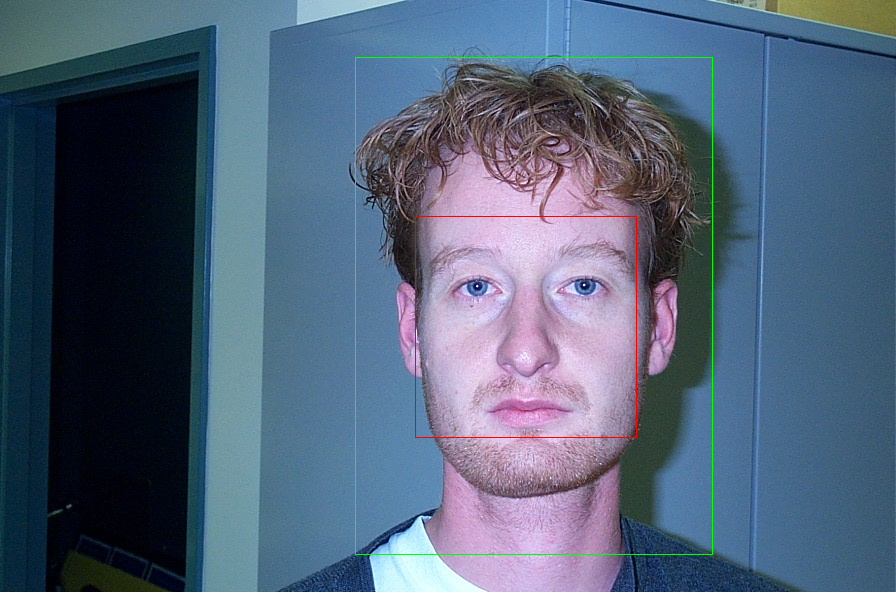

In [ ]:
#@title Pascal Face problem
img = '/content/drive/MyDrive/Datasets/FaceDetection/PascalFace/test/images/image_0242.png'

real = { 
    "top_left": (355, 57), 
    "bottom_right": (712, 554)
    }

pred = { 
    "top_left": (415, 216), 
    "bottom_right": (636, 437)
    }

im = cv2.imread(img)

cv2.rectangle(im, real['top_left'], real['bottom_right'], (0,255,0))
cv2.rectangle(im, pred['top_left'], pred['bottom_right'], (0,0,255))
cv2_imshow(im)

# Load dataset

In [7]:
#@title Load Dataset annotations and filenames
#default: load rectangles list
def load_annotations(path, atype='rectangle'):
  filenames = []
  annotations = []
  for filename in os.listdir(path):
    if filename.__contains__(atype):
      filenames.append(filename)
  for filename in filenames:
    raw = open(path + filename)
    doc = {
        'annotations_filename': filename,
        'annotations': json.loads(raw.read())
    }
    annotations.append(doc)
    raw.close()
  return annotations

**Load WiderFace**

In [ ]:
#@title Wider Face loading
DATASET = "WIDERFace"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"


**Load FDDB**

In [8]:
#@title FDDB loading
DATASET = "FDDB"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"
annotations = load_annotations(test_path + "annotations/")
images_folder = test_path

**Load Pascal Face**

In [ ]:
#@title Pascal Face loading
DATASET = "PascalFace"
##########################################################################
DATASET_PATH = f"{ROOT}{DATASET}/"
train_path = f"{DATASET_PATH}train/"
test_path = f"{DATASET_PATH}test/"
annotations = load_annotations(f"{test_path}annotations/")
images_folder = f"{test_path}images/"

# Test Algorithms

**TinaFace**

In [ ]:
# load model
tinaface_path = "/content/drive/MyDrive/Models/FaceDetection/Tinaface_r50_fpn_widerface.pth"
model = torch.load(tinaface_path)
print(model.keys())

**DSFD**

In [ ]:
# run evaluation
evaluate_dsfd_and_write_to_file(annotations, images_folder)

**YOLOFace**

In [ ]:
# run evaluation
evaluate_yoloface_and_write_to_file(annotations, images_folder)

**FaceBoxes**

In [ ]:
evaluate_faceboxes_and_write_to_file(annotations, images_folder)

In [ ]:
#@title Yolo Detector using GPU (or TPU) { vertical-output: true }
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    '''Convert final layer features to bounding box parameters'''

    num_anchors = len(anchors)

    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    # height, width
    grid_shape = K.shape(feats)[1:3]
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
                    [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
                    [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1],
                                                         K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1],
                                                              K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs


def correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''Get corrected boxes'''

    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])

    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes


def boxes_and_scores(feats, anchors, num_classes, input_shape,
                     image_shape):
    '''Process Convolutional layer output'''

    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats,
                                                                anchors,
                                                                num_classes,
                                                                input_shape)
    boxes = correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores


def eval(outputs, anchors, num_classes, image_shape,
         max_boxes=20, score_threshold=.6, iou_threshold=.5):
    '''Evaluate the YOLO model on given input and return filtered boxes'''

    num_layers = len(outputs)
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] if num_layers == 3 else [
        [3, 4, 5], [1, 2, 3]]
    input_shape = K.shape(outputs[0])[1:3] * 32
    boxes = []
    box_scores = []

    for l in range(num_layers):
        _boxes, _box_scores = boxes_and_scores(outputs[l],
                                               anchors[anchor_mask[l]],
                                               num_classes, input_shape,
                                               image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)

    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)

    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []

    for c in range(num_classes):
        # TODO: use Keras backend instead of tf.
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor,
            iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)

    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)

    return boxes_, scores_, classes_


class YOLO(object):
    def __init__(self, args):
        self.args = args
        self.model_path = args.model
        self.classes_path = args.classes
        self.anchors_path = args.anchors
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self._generate()
        self.model_image_size = args.img_size

    def _get_class(self):
        class_names = ['face']
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def _generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith(
            '.h5'), 'Keras model or weights must be a .h5 file'

        # load model, or construct model and load weights
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            # make sure model, anchors and classes match
            self.yolo_model.load_weights(self.model_path)
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                   num_anchors / len(self.yolo_model.output) * (
                           num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'
        print(
            '*** {} model, anchors, and classes loaded.'.format(model_path))

        # generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2,))
        boxes, scores, classes = eval(self.yolo_model.output, self.anchors,
                                           len(self.class_names),
                                           self.input_image_shape,
                                           score_threshold=self.args.score,
                                           iou_threshold=self.args.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start_time = timer()
        if self.model_image_size != (None, None):
            assert self.model_image_size[
                       0] % 32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[
                       1] % 32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(
                reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')
        image_data /= 255.
        # add batch dimension
        image_data = np.expand_dims(image_data, 0)
        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
        print('*** Found {} face(s) for this image'.format(len(out_boxes)))
        end_time = timer()
        print((end_time - start_time) * 1000)
        for i, c in reversed(list(enumerate(out_classes))):
            box = out_boxes[i]
            score = out_scores[i]
            top, left, bottom, right = box

        return out_boxes

    def close_session(self):
        self.sess.close()


def letterbox_image(image, size):
    '''Resize image with unchanged aspect ratio using padding'''

    img_width, img_height = image.size
    w, h = size
    scale = min(w / img_width, h / img_height)
    nw = int(img_width * scale)
    nh = int(img_height * scale)

    image = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128, 128, 128))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))
    return new_image


def detect_img(yolo, img):
    image = Image.open(img)
    bboxes = yolo.detect_image(image)
    print(bboxes)
    #yolo.close_session()

class Args():
    def __init__(self, model="/content/drive/MyDrive/Models/FaceDetection/YOLO_Face.h5", anchors='cfg/yolo_anchors.txt', classes='cfg/face_classes.txt', score=0.5, iou=0.45, img_size=(416,416), output='outputs/'):
        self.model = model
        self.anchors = anchors
        self.classes = classes
        self.score = score
        self.iou = iou
        self.img_size = img_size
        self.output = output

args = Args()
img_path = "/content/drive/MyDrive/Datasets/FaceDetection/WIDERFace/test/images/22--Picnic/22_Picnic_Picnic_22_106.jpg"
yolo = YOLO(args)
detect_img(yolo, img_path)